# **Sesión 3: Procesamiento Avanzado de Imágenes** ⚙️🖼️

## **Instalaciones**

In [1]:
!pip install tqdm scikit-learn openpyxl pandas matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Librerías**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from bow import BoW
from dataset import Dataset
from image_classifier import ImageClassifier
import time
from tqdm import tqdm
import sys
import pickle
import os
import glob

# **Apartado C**: Detección de puntos de interés y Bolsa de palabras

## **C1: Detección de puntos de interés**

### **Tarea C.1.1**: Generar función de filtro gaussiano

Se generará a partir de la imagen base las imágenes con el filtrado gaussiano. Para ello se empleará la función `generateGaussianImages()` que tiene que desarrollar empleando la función [`cv2.GaussianBlur()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gae8bdcd9154ed5ca3cbc1766d960f45c1). Es recomendble visualizar los resultados para comprobar el funcionamiento. Para ello convierta los datos de la imagen a visualizar a `np.uint8`

In [3]:
folder_name = "partC"
folder_path = os.path.join(os.path.dirname(os.getcwd()), folder_name)
os.makedirs(folder_path, exist_ok=True)

In [4]:
source_paths = sorted(glob.glob("../data/*.jpg"))
print("source_paths:", source_paths)

source_paths: ['../data\\0.jpg', '../data\\0_rot.jpg']


In [5]:
def generateGaussianImages(image, sigmas):
    """Generate the gaussian images using the base image and the sigmas given

    Args:
        image (np.array[np.float32]): Base image to blur
        sigmas (List[np.float32]): Sigmas for blurring the image 

    Returns:
        List[np.array[np.float32]: List of blurred images
    """
    gaussian_images = []

    # Generate blurred images for each sigma
    for sigma in sigmas:
        # Apply Gaussian blur with the current sigma value
        image = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma, sigmaY=sigma)
        gaussian_images.append(image)
    
    return gaussian_images

### **Tarea C.1.2**: Generación de espacio de escalas con imágenes gaussianas

Empleando la función anterior, complete la siguiente celda para generar las imágenes gaussianas

In [6]:

# Load the image and convert to float32
image = cv2.imread(source_paths[0], cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)


# Number of Difference of Gaussians to generate
intervals = 30  # Adjust this number if needed for more keypoints

# Initial sigma value
sigma = 1.6

# Get the sigma values
sigmas = generateGaussianSigmas(sigma, intervals)

# Generate the Gaussian images using the generated sigmas
gaussian_images = generateGaussianImages(image, sigmas)
for img, sigma in zip(gaussian_images, sigmas):
    cv2.imwrite(f"{folder_path}/gaussian_{round(sigma, 2)}.jpg", img)

### **Tarea C.1.3**: Generación de diferencias de gaussianas

Utilizando la lista de imágenes gaussianas se generará una lista con las diferencias entre pares consegutivos. Para ello se empleará la función `generateDoGImages()` que tiene que desarrollar empleando la función [`cv2.subtract()`](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaa0f00d98b4b5edeaeb7b8333b2de353b)

In [7]:
def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians list

    Args:
        gaussian_images (List[np.array[np.float32]): List of blurred images

    Returns:
        List[np.array[np.float32]: List of difference of gaussian images
    """
    dog_images = []

    # Generate the list of Difference-of-Gaussians
    for i, (first_img, second_img) in enumerate(zip(gaussian_images, gaussian_images[1:])):
        # Compute the difference between consecutive Gaussian images
        dog_img = cv2.subtract(second_img, first_img)
        dog_images.append(dog_img)
    
    return dog_images

dog_images = generateDoGImages(gaussian_images)


for img, sigma in zip(dog_images, sigmas[1:]):
    cv2.imwrite(f"{folder_path}/dog_{round(sigma, 2)}.jpg", img)

### **Tarea C.1.4**: Evaluación de extremos

La función `isPixelAnExtremum()` debe evaluar si el pixel central del bloque compuesto por las regiones de las 3 imágenes es un máximo o mínimo entre ellos. Como prevención, tenga en cuenta que puede tomar valores positivos y negativos

In [8]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 array composed of subimages is strictly greater than or less than all its neighbors, False otherwise.

    Args:
        first_subimage (np.array): Patch from first gaussian
        second_subimage (np.array): Patch from second gaussian
        third_subimage (np.array): Patch from third gaussian
        threshold (float): Value threshold for the pixel

    Returns:
        bool: True if maximum or minimum, False otherwise
    """
    extremum = False
    point = second_subimage[1, 1]

    if abs(point) < threshold:
        return extremum
    
    if point < first_subimage.min() and point < third_subimage.min():
        extremum = True
        cont_i = 0
        for i in second_subimage:
            cont_j = 0
            for j in i:
                if point >= j and not (cont_i == 1 and cont_j == 1):
                    extremum = False
                cont_j += 1
            cont_i += 1
        return extremum
    
    if point > first_subimage.max() and point > third_subimage.max():
        extremum = True
        cont_i = 0
        for i in second_subimage:
            cont_j = 0
            for j in i:
                if point <= j and not (cont_i == 1 and cont_j == 1):
                    extremum = False
                cont_j += 1
            cont_i += 1
        return extremum

    return extremum

In [9]:
first_subimage = np.ones((3,3),np.float32)
third_subimage = np.ones((3,3),np.float32)
second_subimage = np.ones((3,3),np.float32)
second_subimage[1,1] = -0.1
isPixelAnExtremum(first_subimage, second_subimage, third_subimage, 0.03)

True

### **Tarea C.1.5**: Localización de puntos clave y orientación de los mismos

La función `findScaleSpaceExtrema()` obtendrá los puntos clave y su orientación a partir de las gaussianas y sus diferencias empleando, entre otras, la función `isPixelAnExtremum()`. Deberá completar las partes indicadas para recorrer todos los trios de imágenes consecutivos y evaluar los píxeles necesarios de estos.

Number of keypoints: 42


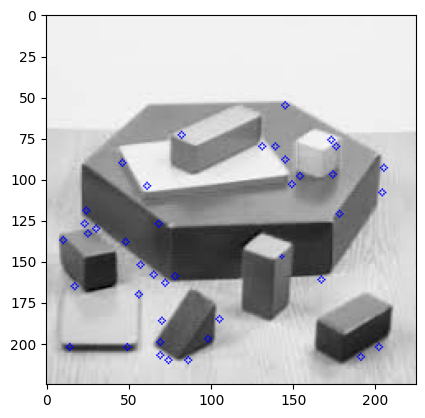

In [10]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, threshold=0.03):
    """Find pixel positions of all scale-space extrema in the image pyramid """
    keypoints = []

    # Fill the loop source data
    for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images[:-2], dog_images[1:-1], dog_images[2:])):
        # (i, j) is the center of the 3x3 array
        # Fill the 2 range limits knowing you have to move the 3x3 window across the whole image
        for i in range(0, first_image.shape[0] - 2):
            for j in range(0, first_image.shape[1] - 2):
                # Fill the method with the required arguments
                if isPixelAnExtremum(first_image[i:i+3, j:j+3], second_image[i:i+3, j:j+3], third_image[i:i+3, j:j+3], threshold):
                    # Refine the keypoint localization
                    localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, num_intervals, dog_images, sigma)
                    if localization_result is not None:
                        keypoint, localized_image_index = localization_result
                        # Get the keypoint orientation
                        keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, gaussian_images[localized_image_index])
                        for keypoint_with_orientation in keypoints_with_orientations:
                            keypoints.append(keypoint_with_orientation)
    return keypoints

# Keypoint Detection with Taylor Expansion and Contrast Thresholding
threshold = 0.03

image = cv2.imread(source_paths[0], cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, intervals, sigma, threshold)
keypoints = removeDuplicateKeypoints(keypoints)
print(f"Number of keypoints: {len(keypoints)}")
visualizeKp(image, keypoints)



Con los puntos clave totalmente definidos y las imágenes gaussianas ya podemos obtener los descriptores con la función proporcionada de `generateDescriptors()`

In [11]:
descriptors = generateDescriptors(keypoints, gaussian_images)

### **Tarea C.1.6**: Pipeline de generación de puntos clave y descriptores

Complete la función con los métodos desarrollados en tareas previas para generar los puntos clave y descriptores necesarios dada una imagen, un valor de sigma y un número de diferencias de gaussianas

In [12]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=10):
    """Compute SIFT keypoints and descriptors for an input image."""
    
    # Convert the image to float32
    image = image.astype('float32')
    
    # Step 1: Generate Gaussian kernels
    gaussian_kernels = generateGaussianSigmas(sigma, num_intervals)
    
    # Step 2: Generate Gaussian blurred images (Gaussian pyramid)
    gaussian_images = generateGaussianImages(image, gaussian_kernels)
    
    # Step 3: Generate Difference of Gaussian (DoG) images
    dog_images = generateDoGImages(gaussian_images)
    
    # Step 4: Detect keypoints in DoG images
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma)
    
    # Step 5: Remove duplicate keypoints
    keypoints = removeDuplicateKeypoints(keypoints)
    
    # Step 6: Generate descriptors for each keypoint
    descriptors = generateDescriptors(keypoints, gaussian_images)
    
    return keypoints, descriptors

### **Tarea C.1.7**: Correspondencia de características entre imágenes

Cargue las imágenes con `cv2` y complete la llamada a la función previa

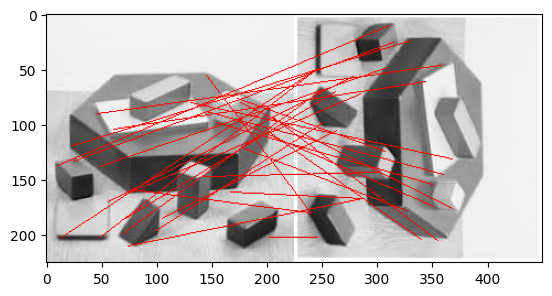

In [13]:
import cv2

sigma = 1.6
threshold = 0.03
intervals = 30

# Load the images with cv2 in grayscale
img1 = cv2.imread(source_paths[0], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(source_paths[1], cv2.IMREAD_GRAYSCALE)

# Compute keypoints and descriptors for each image
kp1, des1 = computeKeypointsAndDescriptors(img1, sigma, intervals)
kp2, des2 = computeKeypointsAndDescriptors(img2, sigma, intervals)

# Match features between the two images
matchFeatures(img1, kp1, des1, img2, kp2, des2)


#### **Ampliación**: SIFT con OpenCV

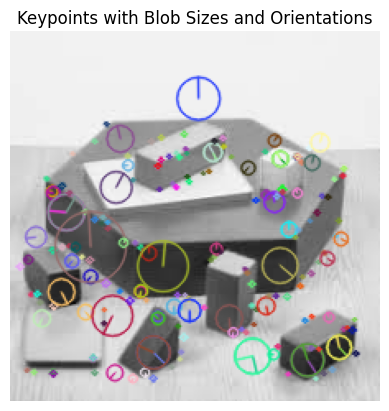

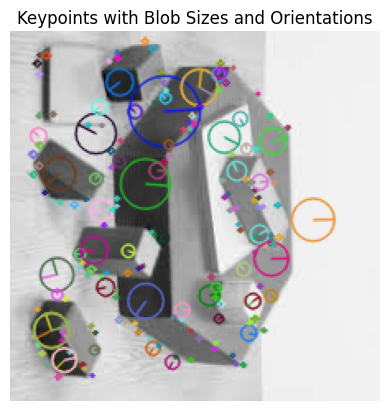

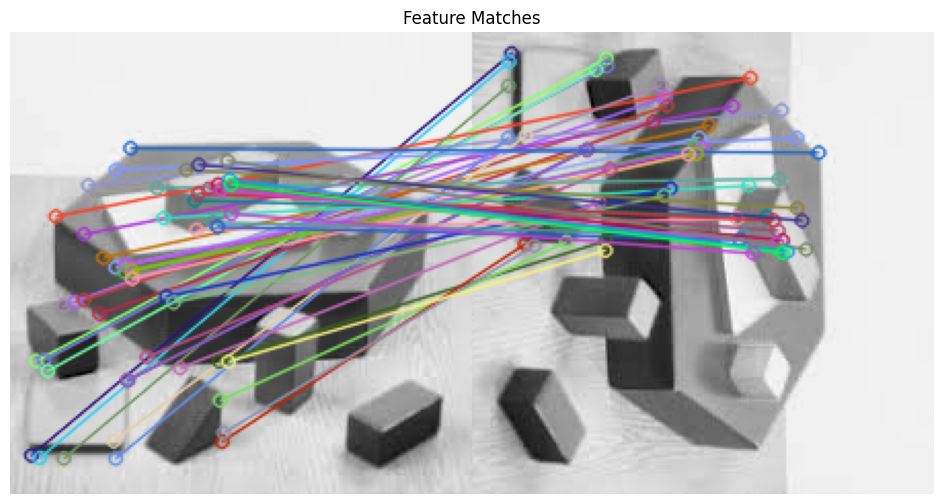

In [14]:
# Load the image
image_0 = cv2.imread('../data/0.jpg', cv2.IMREAD_GRAYSCALE)
image_1 = cv2.imread('../data/0_rot.jpg', cv2.IMREAD_GRAYSCALE)

# Create a SIFT detector object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_0, descriptors_0 = sift.detectAndCompute(image_0, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)

# Draw keypoints on the image
image_with_keypoints_0 = cv2.drawKeypoints(image_0, keypoints_0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_1 = cv2.drawKeypoints(image_1, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints_0)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()
plt.imshow(image_with_keypoints_1)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()

# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Perform KNN matching with k=2 for ratio test
matches = bf.match(descriptors_0, descriptors_1)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)


# Draw the good matches
matched_image = cv2.drawMatches(image_0, keypoints_0, image_1, keypoints_1, matches[:50], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_image)
plt.title("Feature Matches")
plt.axis('off')
plt.show()

### **Pregunta C1**: Correspodencia de imágenes propias y evaluación

In [ ]:
source_paths = sorted(glob.glob("../data/My_photos/*"))
img_1 = cv2.imread(source_paths[0], cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread(source_paths[1], cv2.IMREAD_GRAYSCALE)

def show_image(img, title='image'):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

show_image(img_1)
show_image(img_2)

KeyboardInterrupt: 

: 

In [ ]:
sigma = 1.6
intervals = 10
threshold = 0.03

# Compute keypoints and descriptors for each image
kp1, des1 = computeKeypointsAndDescriptors(img_1, sigma, intervals)
kp2, des2 = computeKeypointsAndDescriptors(img_2, sigma, intervals)

IndexError: index 2 is out of bounds for axis 2 with size 0

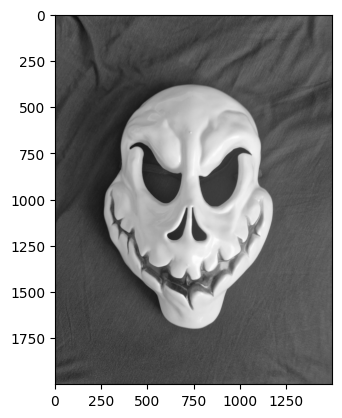

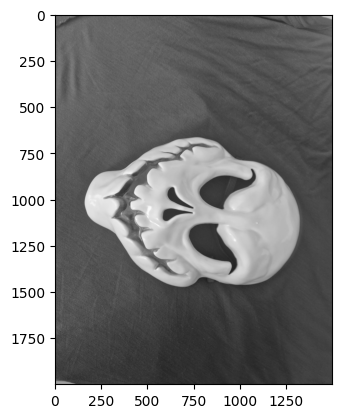

In [ ]:
visualizeKp(img_1, kp1)
visualizeKp(img_2, kp2)

In [ ]:
# Match features between the two images
matchFeatures(img_1, kp1, des1, img_2, kp2, des2)

## **C2: Bolsa de palabras**

### **Tarea C.2.1**: Carga de los datasets de entrenamiento y validación para la bolsa de palabras

Empleando el método `load()` de la clase [`Dataset`](.\dataset.py) que se le proporciona, cargue los datasets de entrenamiento y validación.

In [1]:
source_path = sorted(glob.glob("../data/dataset/*"))
training_path = source_path[0]
validation_path = source_path[1]

training_set = Dataset.load(training_path, ".jpg")
validation_set = Dataset.load(validation_path, ".jpg")

NameError: name 'glob' is not defined

### **Tarea C.2.2**: Extracción de los descriptores

Para poder crear la bolsa de palabras se va a comenzar obteniendo los descriptores que serán agrupados en las distintas palabras de nuestra bolsa. Para ello complete la carga de la imagen en la ruta `path` en escala de grises y obtenga sus descriptores con los métodos apropiados de cv2. Los descriptores obtenidos se añadirán a nuestra bolsa de palabras (`words`) para después ser agrupados por palabras que representen

In [ ]:
feature_extractor = cv2.SIFT_create()

# Extract features
print("\nComputing SIFT descriptors...")
time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # TODO: Load the image from the path in grayscale
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        # TODO: Using the cv2 methods get the descriptors for the image
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)


Computing SIFT descriptors...
100%|██████████| 2981/2981 [00:29<00:00, 102.05image/s]


### **Tarea C.2.3**: Creación del vocabulario

Añada los descriptores a la bolsa (`words`) con el método add de la misma. Con los descriptores en la bolsa, se va a realizar el agrupamiento de los mismos por palabras para obtener un vocabulario de palabras visuales. Complete la ruta de apertura del archivo y establezca el modo de apertura en escrituria y bineario para poder guardar el vocabulario generado.

In [ ]:
# Build vocabulary
vocabulary_size = 100
iterations = 20
termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)
# The descriptors are a simple list of numpy arrays


# TODO: Add all descriptors
for descriptor in descriptors:
    words.add(descriptor)

time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
vocabulary = words.cluster()
filename=  "vocabulary.pickle"
# TODO: Open the file from above in the write and binay mode
with open(filename, 'wb') as f:
    pickle.dump(["SIFT", vocabulary], f, pickle.HIGHEST_PROTOCOL)


Clustering descriptors into 100 words using K-means...


### **Tarea C.2.4**: Entrenamiento del clasificador

Una vez se tiene el vocabulario de palabras visuales, se va a entrenar al classificador. Para ello haga uso de la clase [BoW](./bow.py) y complete los métodos que se le indican

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
file_path = os.path.join(os.path.dirname(os.getcwd()), "src/vocabulary")
bow.load_vocabulary(file_path)

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the training method
image_classifier.train(training_set)
classifier = "classifier"
image_classifier.save(classifier)



TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [00:52<00:00, 57.22image/s]

Training SVM...


### **Tarea C.2.5**: Inferencia en dataset de entrenamiento
Con el modelo entrenado se procede a comprobar su desempeño con el dataset de entrenamiento. Complete los métodos indicados

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary(file_path)

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load(classifier)
# TODO: Especify the args for the loading method
image_classifier.predict(training_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             29.0    2.0     2.0      1.0        18.0          6.0      2.0         26.0       4.0     6.0           2.0    8.0     4.0     1.0            5.0
Coast                2.0  179.0     8.0     12.0         2.0          2.0      0.0          0.0      17.0     1.0          23.0    1.0     2.0     3.0            8.0
Forest               0.0    0.0   209.0      0.0         1.0          0.0      0.0          0.0       7.0     0.0          10.0    1.0     0.0     0.0            0.0
Highway              1.0   35.0     0.0     65.0        12.0          3.0      0.0          0.0       7.0     0.0           6.0    2.0    13.0     7.0            9.0
Industrial           5.0    6.0     2.0      2.0        94.0         26.0      1.0         12.0      10.0     3.0           3.

(0.5897349882589735,
 array([[ 29.,   2.,   2.,   1.,  18.,   6.,   2.,  26.,   4.,   6.,   2.,   8.,   4.,   1.,   5.],
        [  2., 179.,   8.,  12.,   2.,   2.,   0.,   0.,  17.,   1.,  23.,   1.,   2.,   3.,   8.],
        [  0.,   0., 209.,   0.,   1.,   0.,   0.,   0.,   7.,   0.,  10.,   1.,   0.,   0.,   0.],
        [  1.,  35.,   0.,  65.,  12.,   3.,   0.,   0.,   7.,   0.,   6.,   2.,  13.,   7.,   9.],
        [  5.,   6.,   2.,   2.,  94.,  26.,   1.,  12.,  10.,   3.,   3.,  20.,  10.,   5.,  12.],
        [  2.,   1.,   0.,   6.,  18., 137.,   0.,   6.,   0.,   1.,   3.,  11.,  12.,   1.,  10.],
        [  4.,   0.,   0.,   0.,  18.,  22.,  14.,  21.,   0.,  14.,   0.,   6.,   4.,   2.,   4.],
        [  8.,   1.,   0.,   0.,  19.,  11.,   1., 110.,   2.,   6.,   1.,  11.,   6.,   8.,   5.],
        [  0.,  26.,  18.,   1.,   0.,   0.,   0.,   0., 192.,   0.,  29.,   2.,   3.,   1.,   1.],
        [  9.,   0.,   0.,   0.,  13.,  16.,   1.,  32.,   0.,  35.,   0.,   1.

### **Tarea C.2.6**: Inferencia en dataset de evaluación

A continuación se evalua el desempeño del modelo con el dataset de validación. Complete los métodos indicados

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary(file_path)

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load(classifier)
# TODO: Especify the args for the loading method
image_classifier.predict(validation_set)



CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             16.0    5.0     2.0      4.0         7.0          7.0      3.0         23.0       5.0    12.0           1.0    4.0     5.0     1.0            5.0
Coast                1.0   63.0     1.0      5.0         1.0          1.0      0.0          0.0      13.0     0.0          12.0    0.0     0.0     1.0            2.0
Forest               0.0    0.0    90.0      0.0         0.0          0.0      0.0          0.0       4.0     0.0           5.0    0.0     0.0     1.0            0.0
Highway              0.0   30.0     0.0     33.0         3.0          7.0      0.0          1.0       7.0     0.0           3.0    0.0     6.0     5.0            5.0
Industrial           4.0    5.0     1.0      2.0        28.0         17.0      0.0          9.0       3.0     2.0           4.

(0.4886666666666667,
 array([[16.,  5.,  2.,  4.,  7.,  7.,  3., 23.,  5., 12.,  1.,  4.,  5.,  1.,  5.],
        [ 1., 63.,  1.,  5.,  1.,  1.,  0.,  0., 13.,  0., 12.,  0.,  0.,  1.,  2.],
        [ 0.,  0., 90.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  5.,  0.,  0.,  1.,  0.],
        [ 0., 30.,  0., 33.,  3.,  7.,  0.,  1.,  7.,  0.,  3.,  0.,  6.,  5.,  5.],
        [ 4.,  5.,  1.,  2., 28., 17.,  0.,  9.,  3.,  2.,  4.,  9., 11.,  0.,  5.],
        [ 1.,  0.,  0.,  2.,  4., 59.,  0.,  6.,  1.,  3.,  2.,  3.,  7.,  0., 12.],
        [10.,  0.,  0.,  0.,  3., 18., 11., 23.,  0., 13.,  0., 12.,  1.,  2.,  7.],
        [ 5.,  1.,  1.,  0., 10.,  3.,  3., 54.,  1.,  6.,  1.,  7.,  5.,  0.,  3.],
        [ 1.,  7.,  9.,  0.,  0.,  0.,  0.,  0., 67.,  0., 12.,  0.,  3.,  1.,  0.],
        [ 9.,  0.,  0.,  0.,  8., 23.,  1., 27.,  0., 27.,  0.,  1.,  0.,  2.,  2.],
        [ 1., 22.,  9.,  0.,  1.,  0.,  0.,  0., 16.,  0., 47.,  0.,  2.,  2.,  0.],
        [ 1.,  1.,  3.,  0., 10., 10.,  1., 

### **Pregunta C.2.A**: Cambio de SIFT por Kaze

In [4]:
source_path = sorted(glob.glob("../data/dataset/*"))
training_path = source_path[0]
validation_path = source_path[1]

training_set = Dataset.load(training_path, ".jpg")
validation_set = Dataset.load(validation_path, ".jpg")

In [ ]:
#TODO: Homework
feature_extractor = cv2.KAZE_create()

# Extract features
print("\nComputing KAZE descriptors...")
time.sleep(0.1)
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # Load the image from the path in grayscale
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        # Using the cv2 methods get the descriptors for the image
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)

# Build vocabulary
vocabulary_size = 100
iterations = 20
termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

# Add all descriptors
for descriptor in descriptors:
    words.add(descriptor)

time.sleep(0.1)
print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
vocabulary = words.cluster()
filename=  "vocabulary.pickle"
# Open the file from above in the write and binay mode
with open(filename, "wb") as f:
        pickle.dump(["KAZE", vocabulary], f, pickle.HIGHEST_PROTOCOL)

bow = BoW()
# Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# Especify the args for the training method
image_classifier.train(training_set, 20)
classifier = "classifier"
image_classifier.save(classifier)

bow = BoW()
# Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# Especify the args for the loading method
image_classifier.load("classifier")
# Especify the args for the loading method
image_classifier.predict(training_set)

bow = BoW()
# Especify the args for the loading method
bow.load_vocabulary("vocabulary")

image_classifier = ImageClassifier(bow)
# Especify the args for the loading method
image_classifier.load("classifier")
# Especify the args for the loading method
image_classifier.predict(validation_set)


Computing KAZE descriptors...
100%|██████████| 2981/2981 [01:46<00:00, 28.01image/s]

Clustering descriptors into 100 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [03:19<00:00, 14.94image/s]

Training SVM...


CLASSIFICATION RESULTS

Confusion matrix

KNOWN/PREDICTED  Bedroom  Coast  Forest  Highway  Industrial  Inside city  Kitchen  Living room  Mountain  Office  Open country  Store  Street  Suburb  Tall building
Bedroom             53.0    0.0     5.0      1.0         9.0          6.0      7.0         20.0       3.0     6.0           0.0    2.0     0.0     1.0            3.0
Coast                8.0    1.0    17.0     78.0         9.0          5.0      3.0          1.0      57.0     2.0          41.0    1.0     0.0     1.0           36.0
Forest               1.0    0.0   193.0      0.0         6.0          0.0      0.0          1.0      16.0     0.0           2.0    5.0     3.0     0.0            1.0
Highway              0.0    0.0 

(0.30440587449933243,
 array([[25.,  0.,  5.,  2.,  9.,  2.,  8., 29.,  3.,  6.,  2.,  2.,  2.,  1.,  4.],
        [ 1.,  0.,  5., 39.,  0.,  2.,  0.,  2., 29.,  0., 11.,  1.,  1.,  1.,  6.],
        [ 0.,  0., 79.,  0.,  1.,  0.,  0.,  1., 11.,  0.,  1.,  5.,  0.,  1.,  1.],
        [ 1.,  0.,  0., 64.,  6.,  3.,  0.,  0., 13.,  1.,  4.,  0.,  1.,  3.,  4.],
        [ 7.,  0., 12.,  9., 29.,  3.,  0.,  9.,  8.,  2.,  0.,  5.,  3.,  3., 10.],
        [ 6.,  0., 14.,  2.,  6., 27.,  4.,  3.,  1., 14.,  4.,  7.,  2.,  1.,  9.],
        [15.,  0.,  2.,  2.,  7., 16., 11., 23.,  0., 10.,  2.,  5.,  1.,  1.,  5.],
        [18.,  0.,  4.,  0., 12.,  3., 12., 33.,  6.,  7.,  0.,  1.,  0.,  1.,  3.],
        [ 0.,  0., 11., 12.,  6.,  2.,  0.,  0., 51.,  1.,  4.,  0.,  2.,  3.,  8.],
        [ 7.,  0.,  2.,  3.,  8.,  7.,  7., 20.,  6., 30.,  0.,  1.,  1.,  4.,  4.],
        [ 2.,  0., 16., 16.,  4.,  2.,  1.,  1., 24.,  1., 14.,  1.,  2.,  4., 12.],
        [ 2.,  0., 41.,  2.,  7.,  8.,  0.,

### **Pregunta C.2.B**: ¿Cuántas palabras uso?

In [3]:
source_path = sorted(glob.glob("../data/dataset/*"))
training_path = source_path[0]
validation_path = source_path[1]

training_set = Dataset.load(training_path, ".jpg")
validation_set = Dataset.load(validation_path, ".jpg")

In [4]:
feature_extractor = cv2.SIFT_create()

# Extract features
print("\nComputing SIFT descriptors...")
time.sleep(0.1)
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # Load the image from the path in grayscale
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    try:
        # Using the cv2 methods get the descriptors for the image
        _, descriptor = feature_extractor.detectAndCompute(image, None)
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)



Computing SIFT descriptors...
100%|██████████| 2981/2981 [00:28<00:00, 104.10image/s]


In [ ]:
# Build vocabulary
def main(vocabulary_size):
    iterations = 20
    termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
    words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

    # Add all descriptors
    for descriptor in descriptors:
        words.add(descriptor)

    time.sleep(0.1)
    print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
    vocabulary = words.cluster()
    filename=  "vocabulary.pickle"
    # Open the file from above in the write and binay mode
    with open(filename, "wb") as f:
            pickle.dump(["SIFT", vocabulary], f, pickle.HIGHEST_PROTOCOL)

    bow = BoW()
    # Especify the args for the loading method
    bow.load_vocabulary("vocabulary")

    image_classifier = ImageClassifier(bow)
    # Especify the args for the training method
    image_classifier.train(training_set, 20)
    classifier = "classifier"
    image_classifier.save(classifier)

# Cross validation for vocabulary size
vocabulary_sizes = [i for i in range(100, 1000, 50)]
accuracies = []
for vocabulary_size in vocabulary_sizes:
    main(vocabulary_size)
    bow = BoW()
    bow.load_vocabulary("vocabulary")
    image_classifier = ImageClassifier(bow)
    image_classifier.load("classifier")
    accuracy, _, _ = image_classifier.predict(validation_set)
    accuracies.append(accuracy)


Clustering descriptors into 100 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [00:51<00:00, 57.36image/s]

Training SVM...

Clustering descriptors into 150 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [00:54<00:00, 54.27image/s]

Training SVM...

Clustering descriptors into 200 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [00:57<00:00, 52.05image/s]

Training SVM...

Clustering descriptors into 250 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [01:00<00:00, 49.00image/s]

Training SVM...

Clustering descriptors into 300 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [01:04<00:00, 46.32image/s]

Training SVM...

Clustering descriptors into 350 words using K-means...


TRAINING CLASSIFIER

Extracting features...
100%|██████████| 2981/2981 [

100, No hay razonamiento, pero es que no da tiempo a más

### **EXTRA - Pregunta C.2.C**: Buscando los mejóres parámetros

In [ ]:
#TODO: Homework